## 3TM Nickel

In this demonstration we are considering 3 coupled heat diffusion equations, i.e. the 3 temperature model formulated as 

\begin{align}\label{eq:coupledHeatequation}
    \begin{cases}
        C_i^E(\varphi^E)\cdot\rho_i\cdot\partial_t\varphi^E &= \partial_x\left(k^E_i(\varphi^E_i)\cdot \partial_x\varphi^E_i\right) + G_i^{EL}\cdot(\varphi^L_i-\varphi^E_i)+G_i^{SE}\cdot(\varphi^S_i-\varphi^E_i) + S(x,t) \\ \nonumber 
        C_i^L(\varphi^L)\cdot\rho_i\cdot\partial_t\varphi^L &= \partial_x\left(k^L_i(\varphi^L_i)\cdot \partial_x\varphi^L_i\right) + G_i^{EL}\cdot(\varphi^E_i-\varphi^L_i)+G_i^{LS}\cdot(\varphi^S_i-\varphi^L_i) \\ \nonumber
        C_i^S(\varphi^S)\cdot\rho_i\cdot\partial_t\varphi^S &= \partial_x\left(k^S_i(\varphi^S_i)\cdot \partial_x\varphi^S_i\right) + G_i^{SE}\cdot(\varphi^E_i-\varphi^S_i)+G_i^{LS}\cdot(\varphi^L_i-\varphi^S_i)
    \end{cases}
\end{align}
Where the superindex indicates each individual system "E" = Electron, "L" = Lattice, "S" = Spin, and the subindex "i" indicates that we can, with this solver find solutions to multiple piece wise homogeneous layers. 


### Aim
* Calculate the energy deposit in a Nickel film via the transfer matrix method. 
* Do a 3 temperature simulation and calculate the temperature dynamics within a Nickel layer in space and time
* Depict results
* Compare them to [Ultrafast Spin Dynamics in Ferromagnetic Nickel](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.76.4250)
* [Numerical Units](https://pypi.org/project/numericalunits/) is not required but used here to make the physical dimension of the variables used more clear. 

### Setup
* Initially the electron and phonon temperature of Nickel is at 300 K 
* The heating occurs through a laser source, gaussian in time and exponentially decaying in space. The fluence is of the 400 nm laser light is $5 \mathrm{mJ/cm^{2}}$, the polarization is "p" and the incident angle is 45°. 
* A 20 nm Nickel layer is considered and the physical parameters are taken from [Ultrafast Spin Dynamics in Ferromagnetic Nickel](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.76.4250). 


In [1]:
from NTMpy import NTMpy as ntm
from matplotlib import pyplot as plt
import numpy as np
import numericalunits as u
u.reset_units('SI')

In [2]:
#Define the source, responsible for heating
s               = ntm.source()
s.spaceprofile  = "TMM"
s.timeprofile   = "Gaussian" 
s.FWHM          = 0.1*u.ps
s.fluence       = 5*u.mJ/u.cm**2
s.t0            = 0.5*u.ps
s.polarization  = "p"
s.theta_in      = np.pi/4   #rad (0 is grazing)
s.lambda_vac    = 400       #nm

In order to obtain the correct $C_{e,l,s}(T)$, i.e. heat capacity for all the systems under consideration, we are considering $C_e(T) = \gamma T $, where $\gamma = \frac{6000}{\rho}\mathrm{\frac{J}{kgK}}$ and $C_l = \frac{2\cdot 10^6}{\rho}\mathrm{\frac{J}{kg K}}$ from the paper by _Bigot et al._, mentioned above.

For $C_s$ we are considering the total heat capacity $C_{tot}$, from [here](https://webbook.nist.gov/cgi/cbook.cgi?ID=C7440020&Mask=2&Type=JANAFS&Plot=on#JANAFS) and extract the slope $\gamma_l$ before and the slope after $\gamma_r$ Curie temperature.

This gives us 
\begin{equation}
C_s(T) = \gamma_s T ~\text{  where  }~ \gamma_s = \gamma_l - \gamma_r
\end{equation}

Note, that this way of obtaining the coefficients for the respective heat capacities and the linearization of $C_i$ is an approximation, mainly valid for the low temperature regime.

The coupling constants, responsible for the heat exchange for all the systems are given in the paper by _Bigot et al._
and the heat conductivity, responsible for diffusion is assumed to be 1 $\mathrm{\frac{W}{mK}}$, since for a 20 nm thin film we can confidently assume uniform heating without diffusion playing a major role. 

In [3]:
length      = 20*u.nm
density     = 8.908*u.g/(u.cm**3) 
n_index     = 1.7163+2.5925j
C_l         = 2.2e6*u.J/(u.m**3*u.K)/density
gamma       = 6e3*u.J/(u.m**3*u.K**2)/density
#The units of C_tot = J/kgK --> don´t devide over density any more!
C_tot       = lambda T: np.piecewise(T, [T<600, (T>=600) & (T<700),T>= 700 ], \
                 [lambda T:1/0.058* (13.69160 + 82.49509*(T/1000) - 174.955*(T/1000)**2 + 161.6011*(T/1000)**3),
                  lambda T:1/0.058* (1248.045 - 1257.510*(T/1000) - 165.1266/(T/1000)**2),
                  lambda T:1/0.058* (16.49839 + 18.74913*(T/1000) - 6.639841*(T/1000)**2 + 1.717278*(T/1000)**3)])
C_e         = lambda T: gamma *T
#Extract the slope of the total heat capacity before and after curie temperature
temp = np.linspace(300,2000,5000)
indexl = temp <= 500
indexh = temp > 750
z1  = np.polyfit(temp[indexl],C_tot(temp[indexl]),1)
Ce1 = np.poly1d(z1)
coef1 = Ce1.coef
print("Linear approx before Curie temp:")
print(Ce1)
z2  = np.polyfit(temp[indexh],C_tot(temp[indexh]),1)
Ce2 = np.poly1d(z2)
coef2 = Ce2.coef
print("Linear approx after Curie temp:")
print(Ce2)
gammaS = coef1[0]-coef2[0]
print(f"Difference of slopes gives gammaS: {gammaS:.3f}")
C_s         = lambda Ts: gammaS * Ts
#Conductivity is not so important as we assume uniform heating all get the same conductivity
k           = 1*u.W/(u.m*u.K)
#Coupling constants taken from paper
G_el        = 8e17   *u.W/(u.m**3*u.K)
G_se        = 6e17   *u.W/(u.m**3*u.K)
G_ls        = 0.3e17 *u.W/(u.m**3*u.K) 

Linear approx before Curie temp:
 
0.3633 x + 356.5
Linear approx after Curie temp:
 
0.1833 x + 338.4
Difference of slopes gives gammaS: 0.180


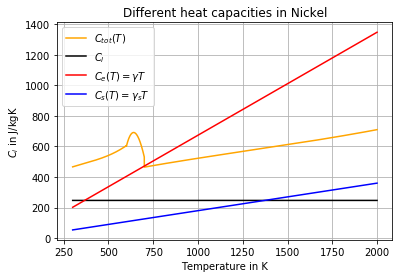

In [4]:
#Depicting the different heat capacities
C_la = C_l*np.ones_like(temp)
plt.figure()
plt.grid()
plt.title("Different heat capacities in Nickel")
plt.xlabel("Temperature in K"); plt.ylabel("$C_i$ in J/kgK")
plt.plot(temp,C_tot(temp),'orange',label = "$C_{tot}(T)$")
plt.plot(temp,C_la,'k',label="$C_l$")
plt.plot(temp,C_e(temp),'r',label = "$C_e(T) =\gamma T$")
plt.plot(temp,C_s(temp),'b',label = "$C_s(T) = \gamma_s T$")
plt.legend(loc='upper left')
plt.show()

Note, that $C_e(T)$ exceeds $C_{tot}$ after Curie temperature. However, the fluence of the laser is too small to cause heating above this temperature. Also we are trying to compare our findings to the paper mentioned above, which is why we are also taking their reported parameters under consideration. 

Now that all the parameters are defined, we can create the simulation object, provide it with the physical properties, which we just evaluated and run the simulation. 
* `sim = simulation(3,s)` creates the simulation object. The input arguments are the number of systems under consideration and the source object, crated above. 
* `sim.addLayer(length,refractive_index,[heat_conductivity],[heat_Capacity], density,[coupling])` crates layer stacks. 
Note that `[heat_conductivity]` is an array, where each entry corresponds to the conductivity of a system. The same holds for `heat_Capacity`. `[coupling]` indicates the linera coupling constant, as indicated in the equation above. Here the first entry of the array corresponds to the coupling between system 1-2; second entry: 2-3; third entry: 3-1. 
* The output of `sim.run()` is the full temperature map of each system. I.e. `Temp_map[0]` corrensponds to the temperature dynamics of the electron system in space, along dim-0 and time, along dim-1. `x` and `t` are vectors contianing the space and time grid respectively. 

Finally we crate the visual object by `v = visual(sim)`, where the simulation object gets passed on as input argument. 

In [5]:
sim               = ntm.simulation(3,s)
sim.addLayer(length,n_index,[k,k,k],[C_e,C_l,C_s],density,[G_el,G_ls,G_se])
sim.final_time    = 8*u.ps
#To get the raw output in form of arrays
[x, t, Temp_map] = sim.run()
#Create a visual object
v = ntm.visual(sim)

-----------------------------------------------------------
 No specific time constant has been indicated. 
 The stability region has been calculated and an appropriate timestep has been chosen.
 Timestep = 5.49e-15 s
-----------------------------------------------------------
Line 728 Spinsystem
-----------------------------------------------------------
Transfer matrix absorption profile and a Gaussian time profile is taken into account for the source.
Length of every layer has to be given in units of meter.
-----------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████| 1549/1549 [00:00<00:00, 2968.66it/s]


-----------------------------------------------------------
Heat diffusion in a coupled electron-latticelspin system has been simulated
Eleapsed time in E.E.- loop: 0.5634047985076904
-----------------------------------------------------------
------------------------------------------------------------
The simulation object of the 3 temerature system has been passed on to the visual class.
------------------------------------------------------------
-----------------------------------------------------------
The maunually chosen time step of 5.49e-15 is very small and will eventually cause a long simulation time.
We suggest a timestep of 2.63e-13 s
-----------------------------------------------------------
Line 728 Spinsystem
-----------------------------------------------------------
Transfer matrix absorption profile and a Gaussian time profile is taken into account for the source.
Length of every layer has to be given in units of meter.
--------------------------------------------

100%|████████████████████████████████████████████████████████████████████████████| 1549/1549 [00:00<00:00, 1932.18it/s]


-----------------------------------------------------------
Heat diffusion in a coupled electron-latticelspin system has been simulated
Eleapsed time in E.E.- loop: 0.8016860485076904
-----------------------------------------------------------


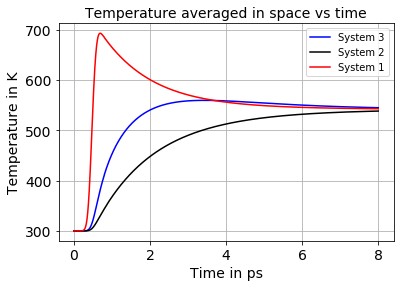

Shape of temp_vec = (3, 1550)


In [6]:
[timegrid,Temp_vec] = v.average()
print("Shape of temp_vec = "+str(np.shape(Temp_vec)))

The function `[timegrid,Temp_vec] = v.average()` has two outputs: the timegrid in vector form and the corresponding averaged temperatures. `Temp_vec` is in array form. That is different rows correspond to different systems and the data for each timestep is storead along the colum direction.

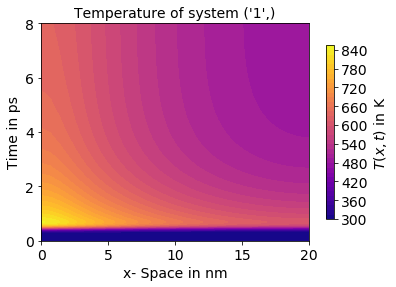

In [7]:
v.contour("1")

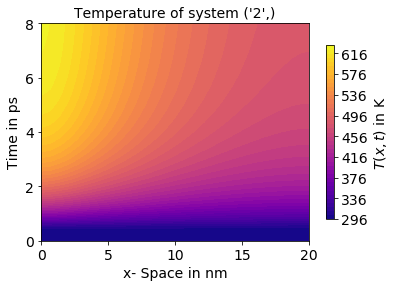

In [8]:
v.contour("2")

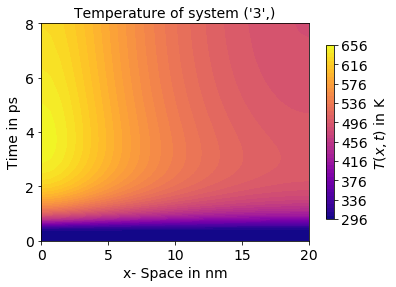

In [9]:
v.contour("3")

Comparing this to Fig. 3, from [Ultrafast Spin Dynamics in Ferromagnetic Nickel](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.76.4250), we see, that our findings are in agreement with what is reported in the paper. 

### New Spin heat capacity

Now let us consider the follwing $C_s$: 
\begin{equation} C_s(T)=
\begin{cases}
\gamma_s T &\text{ for } T<T_C \\ \nonumber
0          &\text{ else }
\end{cases}
\end{equation}
where the Curie temperature $T_C = 650$K 

We redefine $C_s$ and reset the simulation.

In [10]:
C_s = lambda T: np.piecewise(T,[T <= 650, T >= 650], [lambda T: gammaS*T,1e-2])
sim               = simulation(3,s)
sim.addLayer(length,n_index,[k,k,k],[C_e,C_l,C_s],density,[G_el,G_ls,G_se])
sim.final_time    = 8*u.ps
[x, t, Temp_map]= sim.run()
v = visual(sim)

-----------------------------------------------------------
 No specific time constant has been indicated. 
 The stability region has been calculated and an appropriate timestep has been chosen.
 Timestep = 5.49e-15 s
-----------------------------------------------------------
Line 728 Spinsystem
-----------------------------------------------------------
Transfer matrix absorption profile and a Gaussian time profile is taken into account for the source.
Length of every layer has to be given in units of meter.
-----------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████| 1549/1549 [00:00<00:00, 2609.20it/s]


-----------------------------------------------------------
Heat diffusion in a coupled electron-latticelspin system has been simulated
Eleapsed time in E.E.- loop: 0.5936684608459473
-----------------------------------------------------------
------------------------------------------------------------
The simulation object of the 3 temerature system has been passed on to the visual class.
------------------------------------------------------------
-----------------------------------------------------------
The manually chosen time step of 5.49e-15 is eventually too big and could cause instabilities in the simulation.
 We suggest a timestep of 5.49e-17 s
-----------------------------------------------------------
Line 728 Spinsystem
-----------------------------------------------------------
Transfer matrix absorption profile and a Gaussian time profile is taken into account for the source.
Length of every layer has to be given in units of meter.
-------------------------------------

100%|████████████████████████████████████████████████████████████████████████████| 1458/1458 [00:00<00:00, 2483.14it/s]


-----------------------------------------------------------
Heat diffusion in a coupled electron-latticelspin system has been simulated
Eleapsed time in E.E.- loop: 0.5871601104736328
-----------------------------------------------------------


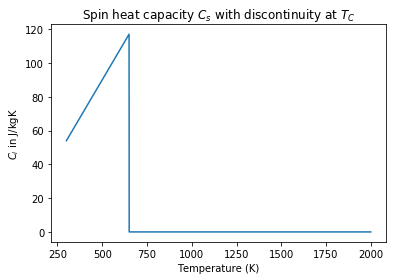

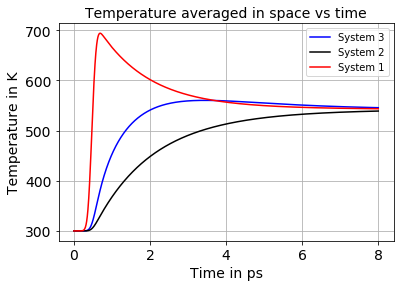

In [11]:
plt.figure()
plt.plot(temp,C_s(temp))
plt.title("Spin heat capacity $C_s$ with discontinuity at $T_C$")
plt.xlabel("Temperature (K)");plt.ylabel("$C_i$ in J/kgK")

[timegrid,Temp_vec] = v.average()

### 1 TM- Simulation

If there is only one system, then the heating should be way stronger on this system, since the heat does not get distributed among different systems. In order to qualitatively check this, we reset the problem and run a simulation again. 

#### Decrease the timestep automatically
Note: In this specific case, the automatically calculated time step for stability calculations would be larger than the FWHM of the laser source. This would lead to an incorrect caption of the laser pulse, since too little time steps would be applied in order to correctly capture the shape of the source. 

Therefore a routine has been implemented, which makes the timestep around the peak of the gaussian smaller, in order to capture its shape and to correctly calculate the energy deposit in time.


In [12]:
#Source
s               = source()
#Those are the default options for space and time profile
#s.spaceprofile  = "TMM"
#s.timeprofile  = "Gaussian" 
s.FWHM          = 0.1*u.ps
s.fluence       = 5*u.mJ/u.cm**2
s.t0            = 0.5*u.ps
s.polarization  = "p"
s.theta_in      = np.pi/4  
s.lambda_vac    = 400      
#1 TM simulation
sim               = simulation(1,s)
sim.addLayer(length,n_index,[k],[C_e],density)
sim.final_time    = 8*u.ps
v = visual(sim)

------------------------------------------------------------
The simulation object of the 1 temerature system has been passed on to the visual class.
------------------------------------------------------------
-----------------------------------------------------------
 No specific time constant has been indicated. 
 The stability region has been calculated and an appropriate timestep has been chosen.
 Timestep = 1.25e-12 s
-----------------------------------------------------------
-----------------------------------------------------------
Transfer matrix absorption profile and a Gaussian time profile is taken into account for the source.
Length of every layer has to be given in units of meter.
-----------------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 206/206 [00:00<00:00, 4392.66it/s]


-----------------------------------------------------------
Electron temperature heat diffusion has been simulated.
Eleapsed time in E.E.- loop: 0.06252121925354004
-----------------------------------------------------------


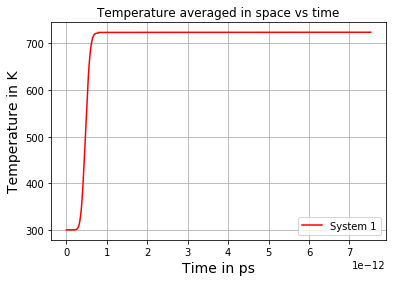

Shape of temp_vec = (207,)


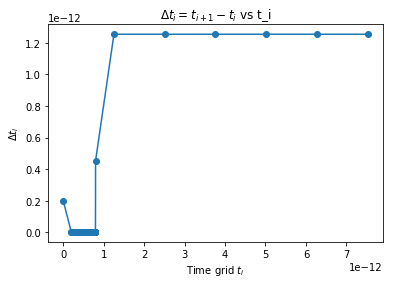

In [13]:
[timegrid,temp_vec] = v.average()
print("Shape of temp_vec = "+str(np.shape(temp_vec)))
v.timegrid()